# HackLive - Guided Community Hackathon!

[Link to competition here!](https://datahack.analyticsvidhya.com/contest/hacklive-guided-community-hackathon/)

Go there and register to be able to download the dataset and submit your predictions. Click the button below to open this notebook in Google Colab!

<a href="https://colab.research.google.com/github/jpraguer/jpraguer.github.io/master/_posts/ClassificationEDABaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Marketing campaigns are characterized by focusing on the customer needs and their overall satisfaction. Nevertheless, there are different variables that determine whether a marketing campaign will be successful or not. Some important aspects of a marketing campaign are as follows: 

- *Segment of the Population:* To which segment of the population is the marketing campaign going to address and why? This aspect of the marketing campaign is extremely important since it will tell to which part of the population should most likely receive the message of the marketing campaign. 

- *Distribution channel to reach the customer's place:* Implementing the most effective strategy in order to get the most out of this marketing campaign. What segment of the population should we address? Which instrument should we use to get our message out? (Ex: Telephones, Radio, TV, Social Media Etc.) 

- *Promotional Strategy:* This is the way the strategy is going to be implemented and how are potential clients going to be address. This should be the last part of the marketing campaign analysis since there has to be an in-depth analysis of previous campaigns (If possible) in order to learn from previous mistakes and to determine how to make the marketing campaign much more effective.

You are leading the marketing analytics team for a banking institution. There has been a revenue decline for the bank and they would like to know what actions to take. After investigation, it was found that the root cause is that their clients are not depositing as frequently as before. Term deposits allow banks to hold onto a deposit for a specific amount of time, so banks can lend more and thus make more profits. In addition, banks also hold better chance to persuade term deposit clients into buying other products such as funds or insurance to further increase their revenues.

You are provided a dataset containing details of marketing campaigns done via phone with various details for customers such as demographics, last campaign details etc. Can you help the bank to predict accurately whether the customer will subscribe to the focus product for the campaign - Term Deposit after the campaign?

In [1]:
!pip install catboost

In [2]:
# import useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

from catboost import CatBoostClassifier, Pool

In [3]:
# load in data and set seed
BASE = 'https://drive.google.com/uc?export=download&id='
SEED = 2021

train = pd.read_csv(f'{BASE}1fNjtZDxlQwwAE5VY7BBJODw7an-Lbob2')
test = pd.read_csv(f'{BASE}1VJUp6Zuww-OphdWBqI5Q2TRK7o1Xh_xn')
ss = pd.read_csv(f'{BASE}19P8qo-6_sykC6uTJQ60eyfmcbYpu0GtR')

In [4]:
# Prepare a few key variables to classify columns into categorical and numeric
ID_COL, TARGET_COL = 'id', 'term_deposit_subscribed'
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]

cat_cols = ['job_type',
 'marital',
 'education',
 'default',
 'housing_loan',
 'personal_loan',
 'communication_type',
 'month',
 'prev_campaign_outcome']

num_cols = [c for c in features if c not in cat_cols]

## EDA starts
First we look at the first few rows of train dataset.

In [5]:
train.head(3)

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0


In [6]:
ss.head(3)

,id,term_deposit_subscribed
0,id_17231,0
1,id_34508,0
2,id_44504,0


In [7]:
# look at distribution of target variable
train[TARGET_COL].value_counts(), train[TARGET_COL].value_counts(normalize=True)

(0    28253
 1     3394
 Name: term_deposit_subscribed, dtype: int64, 0    0.892754
 1    0.107246
 Name: term_deposit_subscribed, dtype: float64)

In [8]:
# look at which variables are null and if they were parsed correctly
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                31647 non-null  object 
 1   customer_age                      31028 non-null  float64
 2   job_type                          31647 non-null  object 
 3   marital                           31497 non-null  object 
 4   education                         31647 non-null  object 
 5   default                           31647 non-null  object 
 6   balance                           31248 non-null  float64
 7   housing_loan                      31647 non-null  object 
 8   personal_loan                     31498 non-null  object 
 9   communication_type                31647 non-null  object 
 10  day_of_month                      31647 non-null  int64  
 11  month                             31647 non-null  object 
 12  last

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13564 entries, 0 to 13563
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                13564 non-null  object 
 1   customer_age                      13294 non-null  float64
 2   job_type                          13564 non-null  object 
 3   marital                           13483 non-null  object 
 4   education                         13564 non-null  object 
 5   default                           13564 non-null  object 
 6   balance                           13383 non-null  float64
 7   housing_loan                      13564 non-null  object 
 8   personal_loan                     13490 non-null  object 
 9   communication_type                13564 non-null  object 
 10  day_of_month                      13564 non-null  int64  
 11  month                             13564 non-null  object 
 12  last

Looks like we have a lot of nulls. :/ Otherwise pandas parsed out the columns quite well.

### Looking at categorical columns
Because of all the categorical columns I decided to set a baseline in Catboost. Here are top 5 value counts and countplots for all of them, they prove useful.

Analysing: job_type
Train top 5 counts:
blue-collar    6816
management     6666
technician     5220
admin.         3627
services       2923
Name: job_type, dtype: int64
Test top 5 counts:
blue-collar    2916
management     2792
technician     2377
admin.         1544
services       1231
Name: job_type, dtype: int64


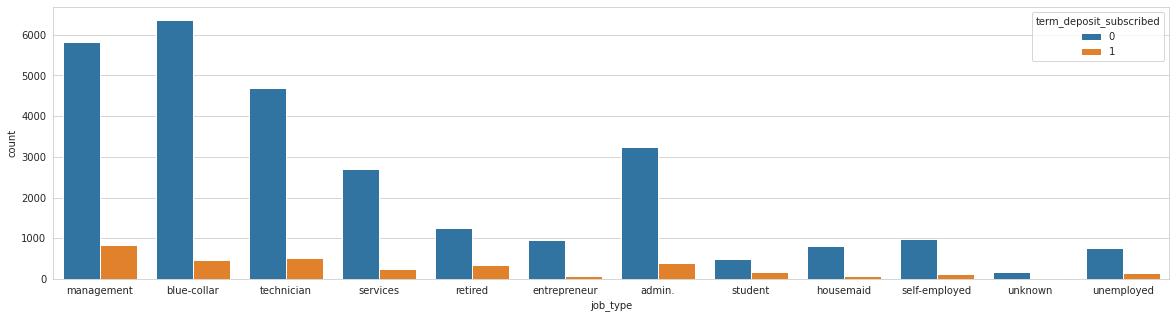



Analysing: marital
Train top 5 counts:
married     18945
single       8857
divorced     3695
Name: marital, dtype: int64
Test top 5 counts:
married     8123
single      3869
divorced    1491
Name: marital, dtype: int64


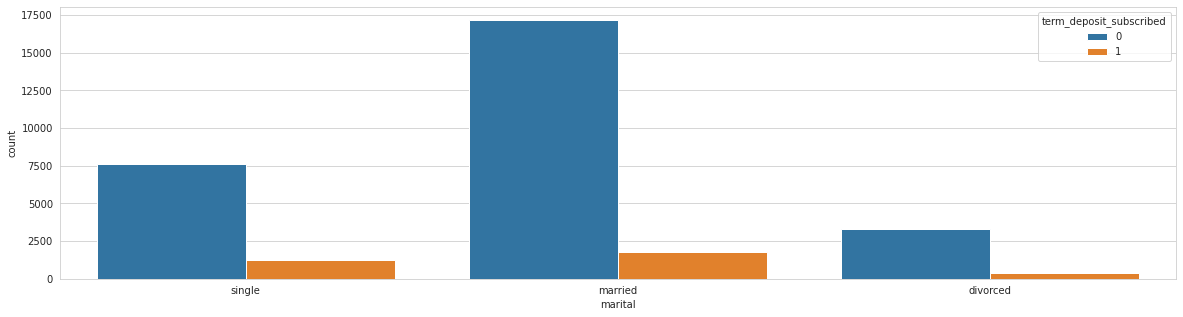



Analysing: education
Train top 5 counts:
secondary    16247
tertiary      9321
primary       4787
unknown       1292
Name: education, dtype: int64
Test top 5 counts:
secondary    6955
tertiary     3980
primary      2064
unknown       565
Name: education, dtype: int64


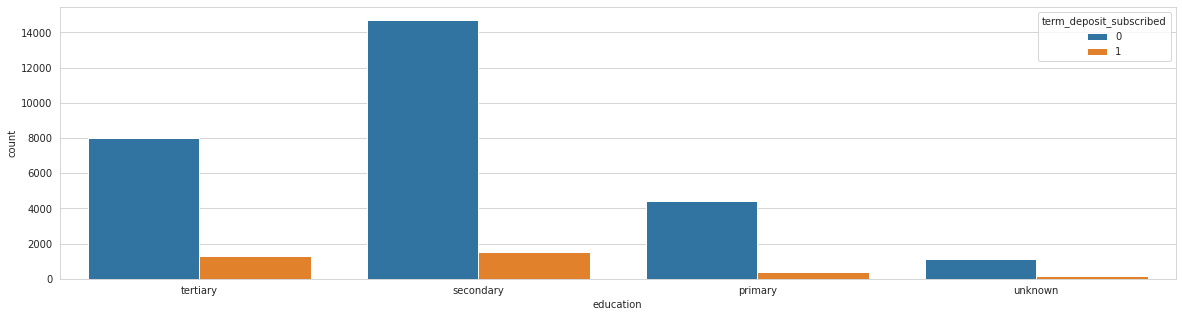



Analysing: default
Train top 5 counts:
no     31094
yes      553
Name: default, dtype: int64
Test top 5 counts:
no     13302
yes      262
Name: default, dtype: int64


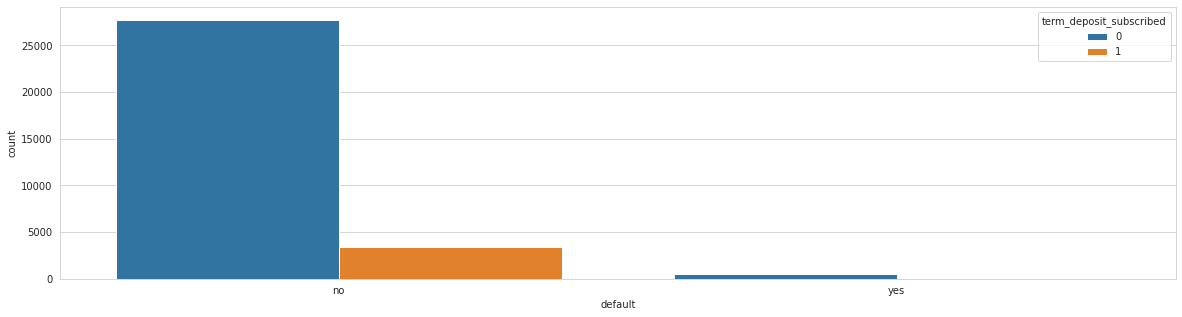



Analysing: housing_loan
Train top 5 counts:
yes    17700
no     13947
Name: housing_loan, dtype: int64
Test top 5 counts:
yes    7430
no     6134
Name: housing_loan, dtype: int64


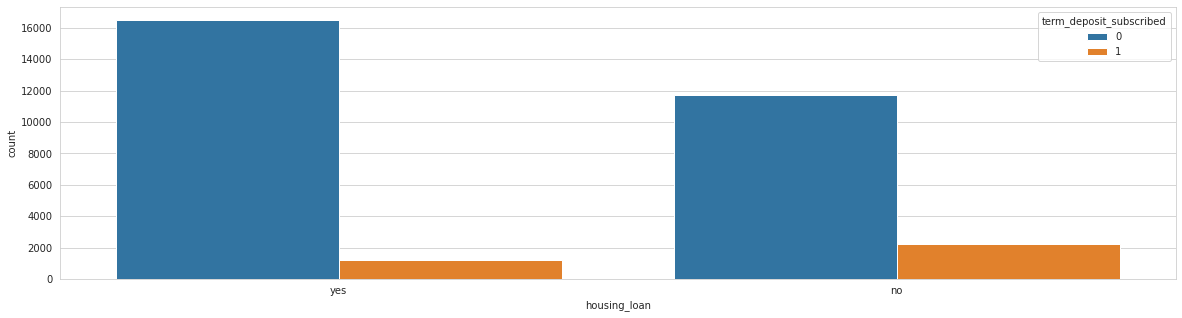



Analysing: personal_loan
Train top 5 counts:
no     26463
yes     5035
Name: personal_loan, dtype: int64
Test top 5 counts:
no     11314
yes     2176
Name: personal_loan, dtype: int64


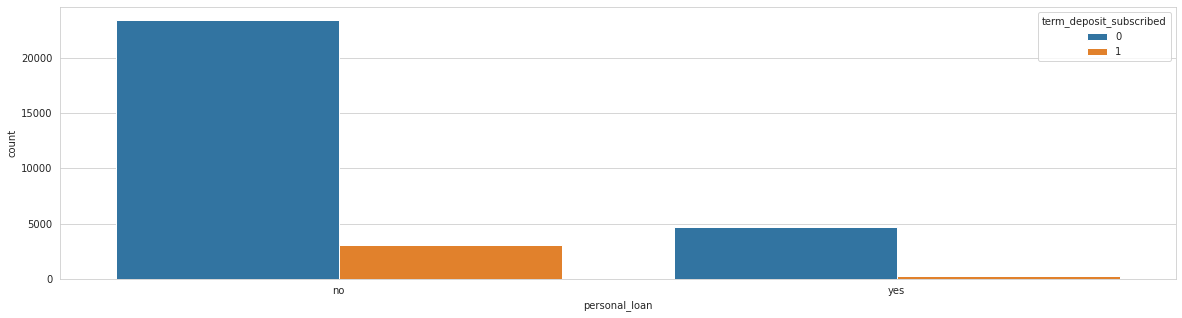



Analysing: communication_type
Train top 5 counts:
cellular     20480
unknown       9151
telephone     2016
Name: communication_type, dtype: int64
Test top 5 counts:
cellular     8805
unknown      3869
telephone     890
Name: communication_type, dtype: int64


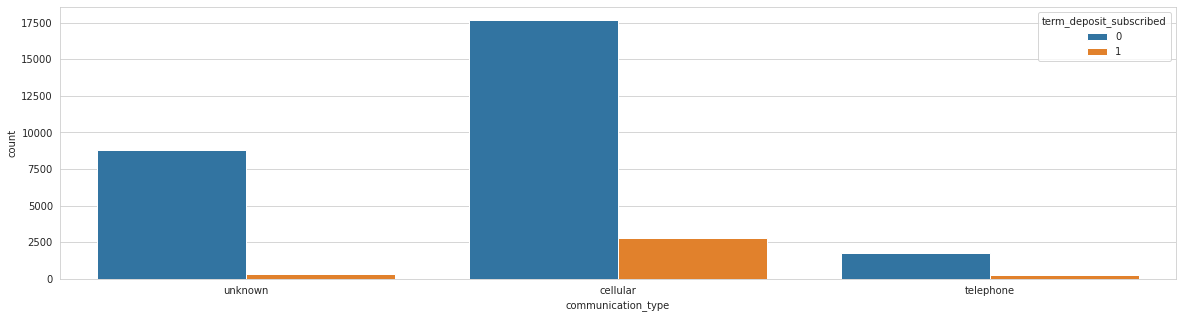



Analysing: month
Train top 5 counts:
may    9685
jul    4786
aug    4308
jun    3746
nov    2801
Name: month, dtype: int64
Test top 5 counts:
may    4081
jul    2109
aug    1939
jun    1595
nov    1169
Name: month, dtype: int64


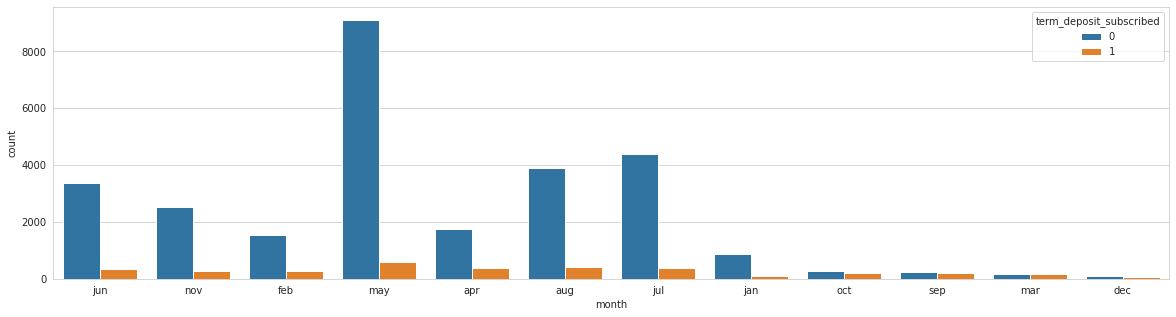



Analysing: prev_campaign_outcome
Train top 5 counts:
unknown    25833
failure     3472
other       1272
success     1070
Name: prev_campaign_outcome, dtype: int64
Test top 5 counts:
unknown    11126
failure     1429
other        568
success      441
Name: prev_campaign_outcome, dtype: int64


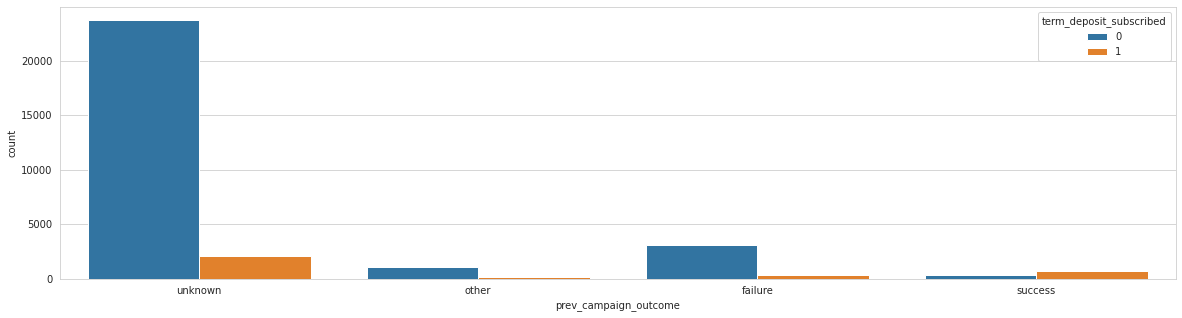

In [10]:
# print top 5 values and plot data wrt target variable (term deposit subscribed)
for col in cat_cols:
  print(f'Analysing: {col}\nTrain top 5 counts:')
  print(train[col].value_counts().head(5))
  print('Test top 5 counts:')
  print(test[col].value_counts().head(5))
  plt.figure(figsize=(20,5))
  sns.countplot(x=col, hue=TARGET_COL, data=train)
  plt.show();
  print('\n')

#### Observations
Here I am interested in the ratio of target variable in each category. If it is a lot different from the other ratios, the signal conveyed for that category is useful. 

Mostly married managers without a default. No housing, no personal loan. Contacted by cell phone.

### Analysis of continuous variables
Plotted boxplots by target variable and kernel density estimates for each continuous variable to draw interesting insight.

Analysing: customer_age


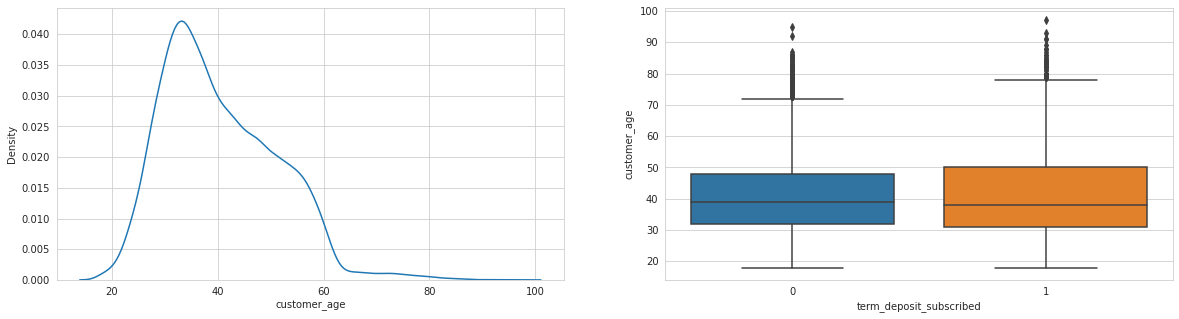



Analysing: balance


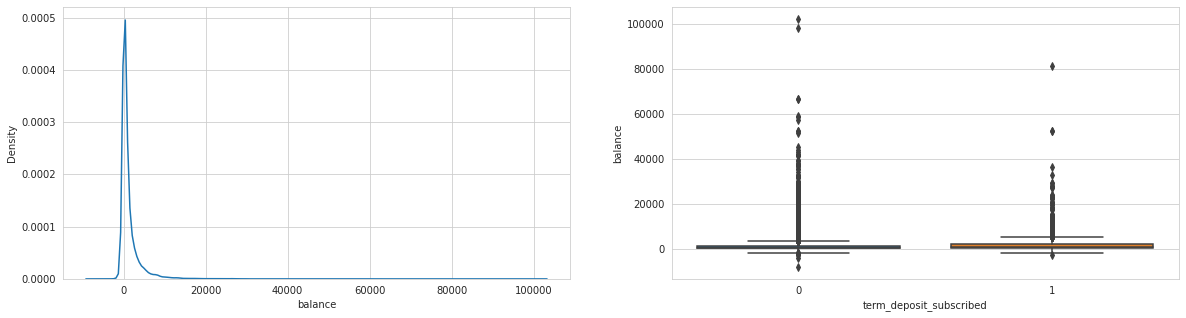



Analysing: day_of_month


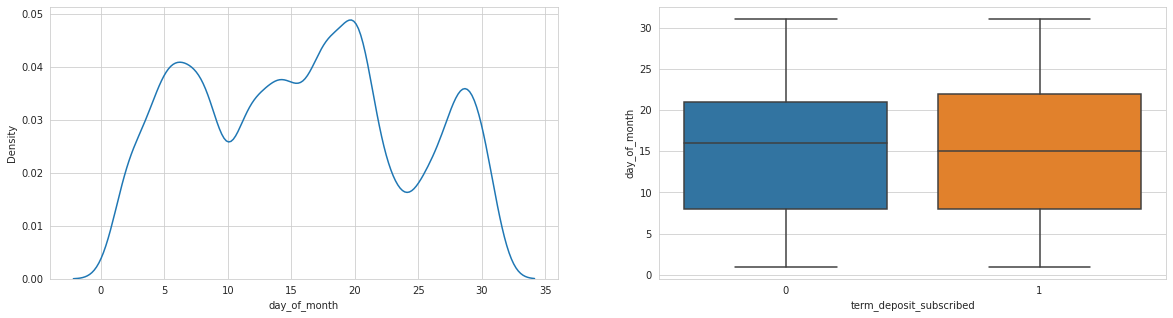



Analysing: last_contact_duration


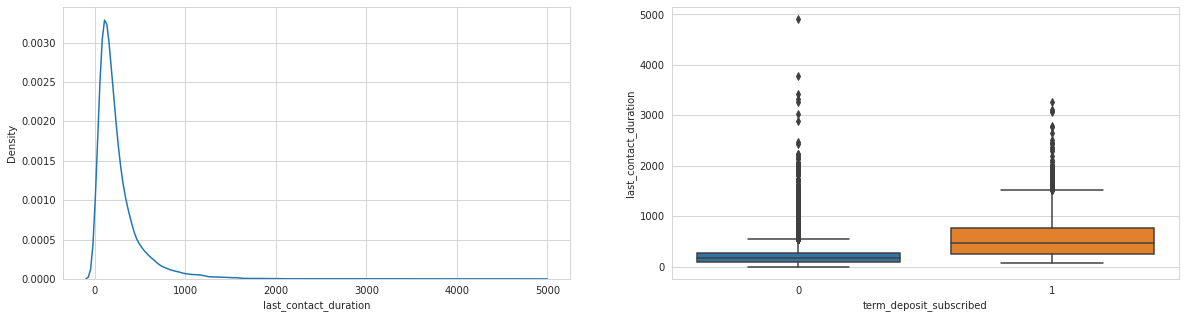



Analysing: num_contacts_in_campaign


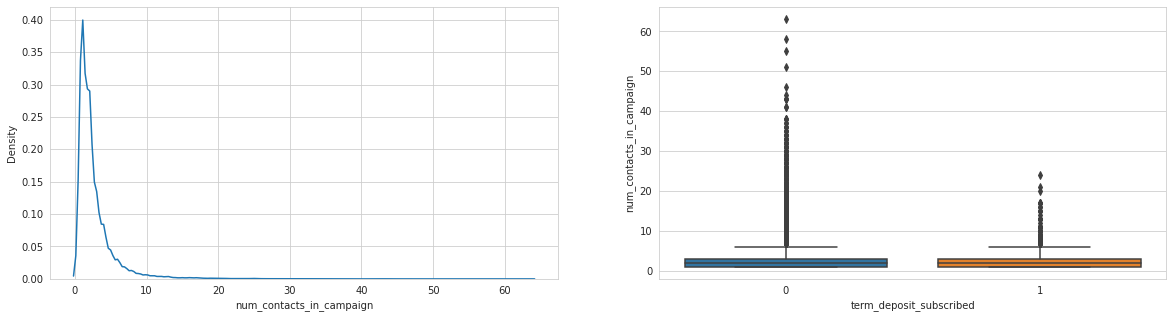



Analysing: days_since_prev_campaign_contact


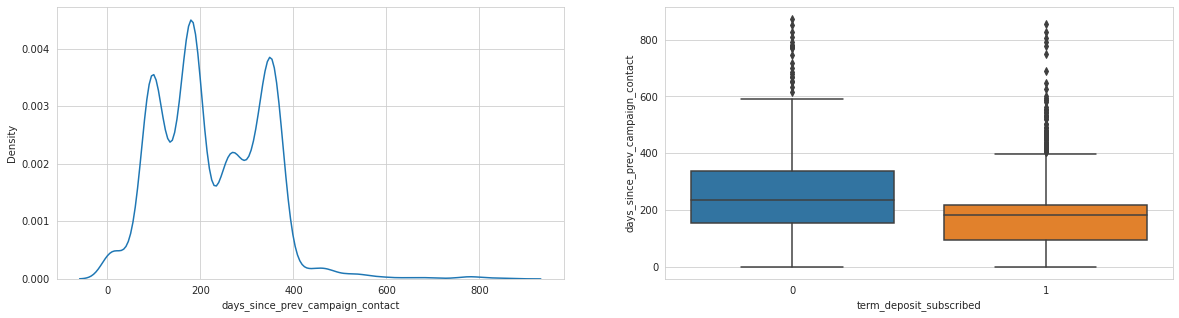



Analysing: num_contacts_prev_campaign


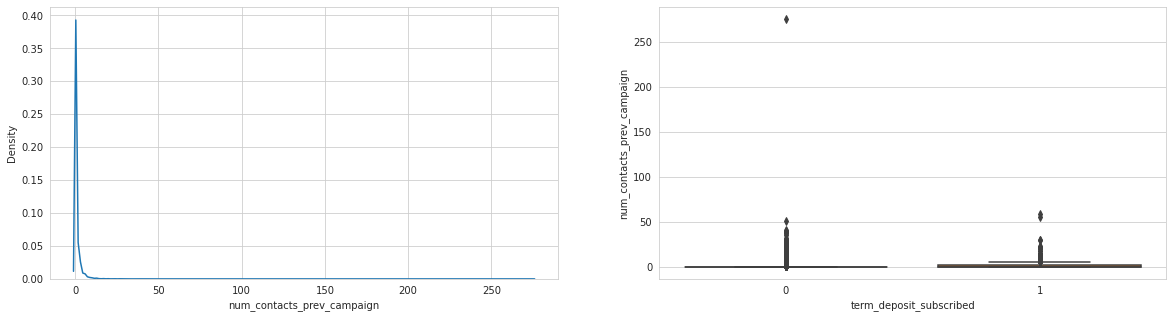

In [11]:
# plot kernel density plot and a boxplot of data wrt target variable (term deposit subscribed)
for col in num_cols:
  print(f'Analysing: {col}')
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
  sns.kdeplot(train[col], ax=ax1)
  sns.boxplot(x = train[TARGET_COL], y = train[col], ax=ax2)
  plt.show();
  print('\n')

#### Observations
Last contact duration, days since previous campaign seem to have an effect, as well as day of month.

Three variables are clearly exponentially distributed, let's plot them log-transformed to properly see their relationships.

Analysing: balance


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


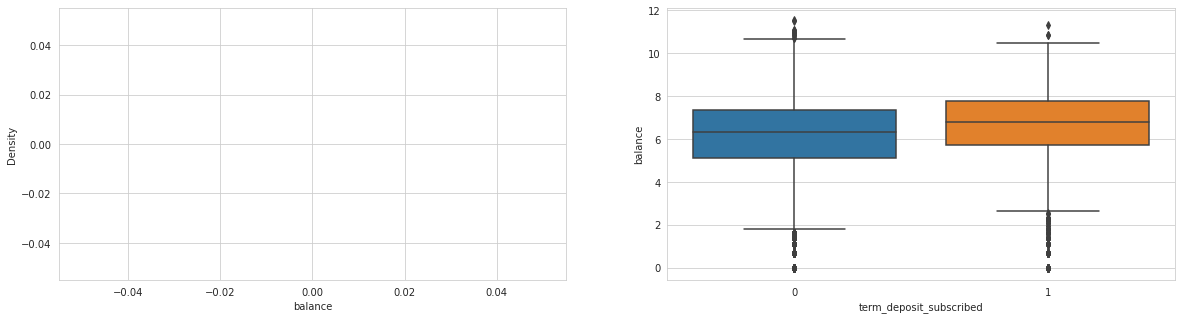



Analysing: last_contact_duration


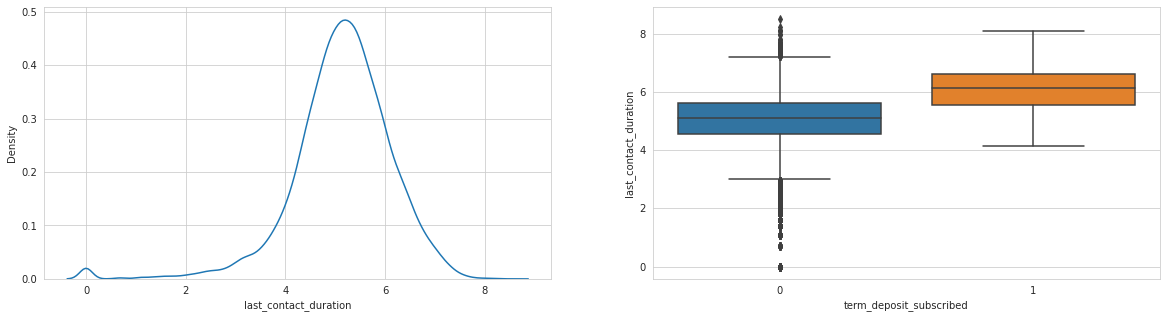



Analysing: num_contacts_prev_campaign


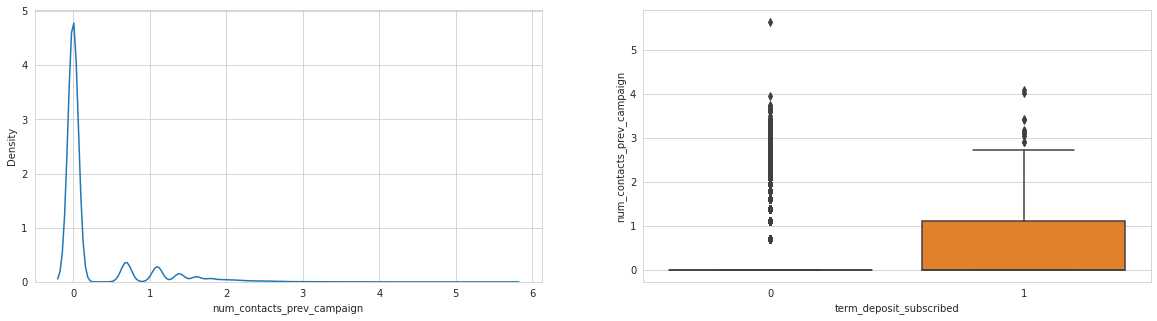

In [12]:
for col in ['balance', 'last_contact_duration', 'num_contacts_prev_campaign']:
  # plot kernel density plot and a boxplot of data wrt target variable (term deposit subscribed)
  print(f'Analysing: {col}')
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
  sns.kdeplot(np.log1p(train[col]), ax=ax1)
  sns.boxplot(x = train[TARGET_COL], y = np.log1p(train[col]), ax=ax2)
  plt.show();
  print('\n')

#### Observations
Looks like `balance` column has some invalid observations => probably negative balances causing issues.

`num_contacts_prev_campaign` with 0 target variable has lots of outliers, quite a strange distribution - worth investigating in the future.

Let's try some bivariate analysis.

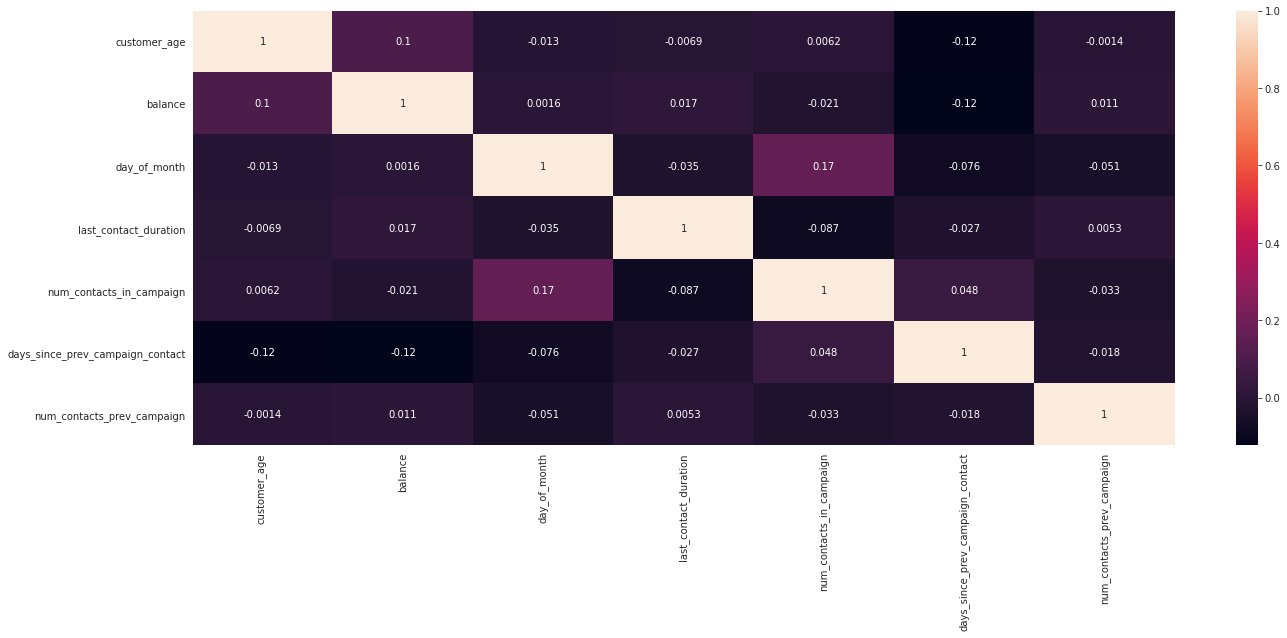

In [13]:
# Correlation heatmap 
# not that useful for classification, especially with GBDTs
# since DT-models are not influenced by multi-collinearity
plt.figure(figsize=(22, 8))
sns.heatmap(train[num_cols].corr(), annot=True);

CPU times: user 11.2 s, sys: 161 ms, total: 11.4 s
Wall time: 11.3 s


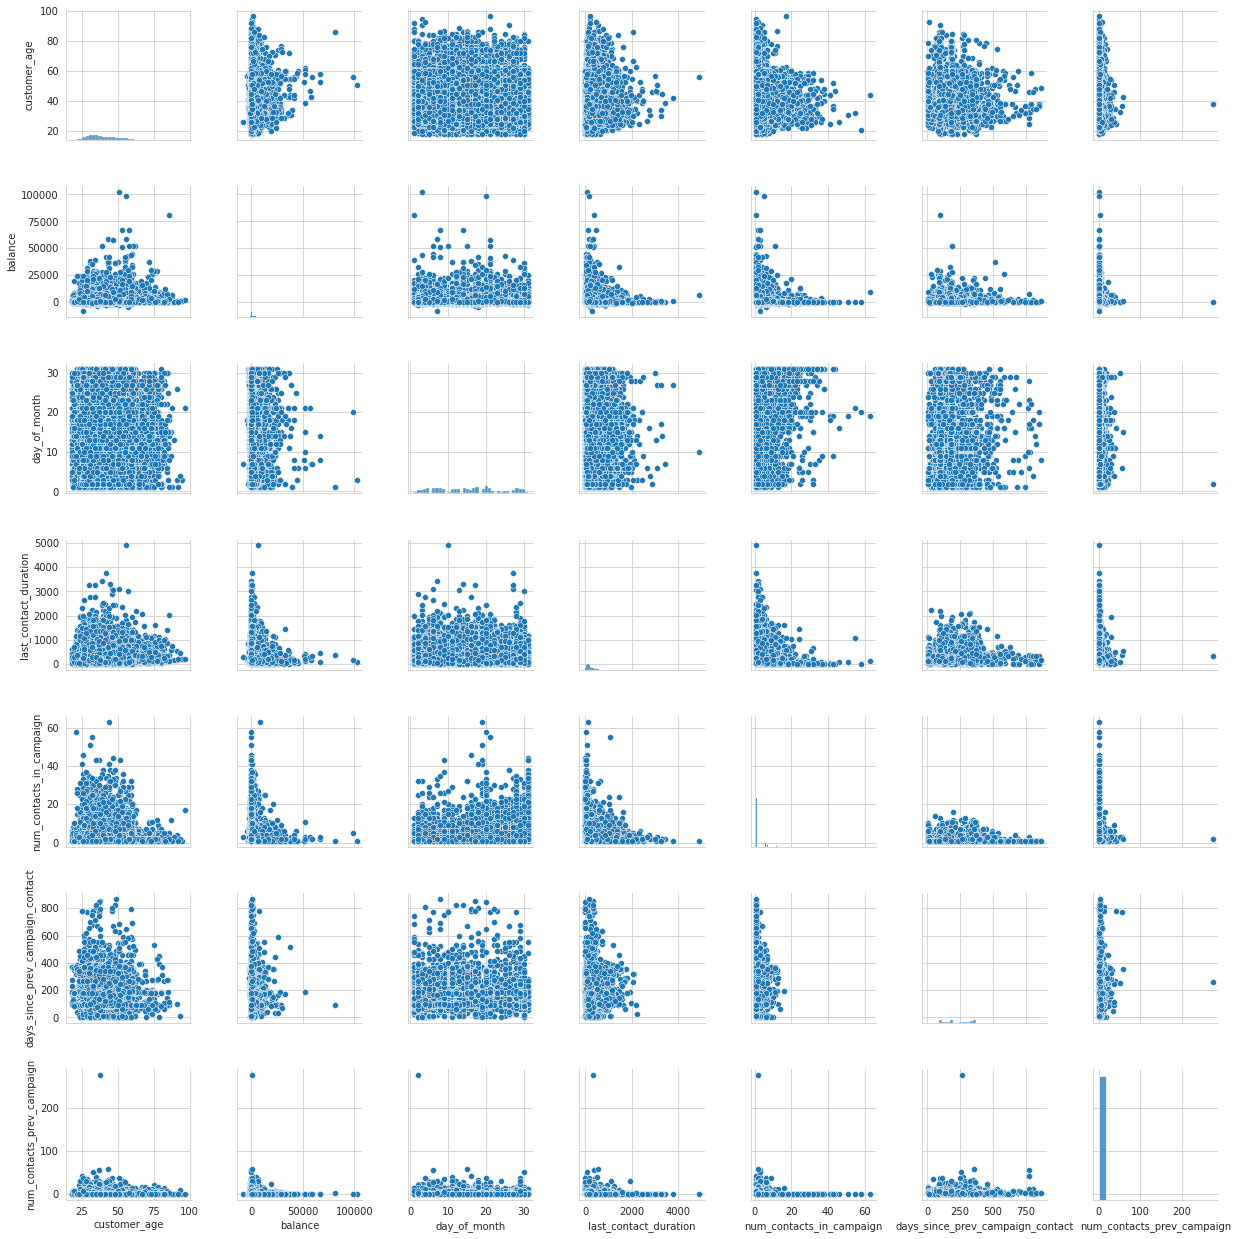

In [14]:
%%time
# Pairplots => these always take long to render
sns.pairplot(train[num_cols]);

## Baseline Model
Alright, after EDA of all variables, it's time to introduce the CatboostClassifier model with no tuning as a baseline.

In [15]:
# Data preparation
y = train[TARGET_COL].values
X = train.drop([TARGET_COL, ID_COL], axis=1)
X.head()

,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome
0,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown
1,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other
2,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown
3,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,NaN,0,unknown
4,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,NaN,0,unknown


In [16]:
# Categorical features reminder
cat_cols

['job_type',
 'marital',
 'education',
 'default',
 'housing_loan',
 'personal_loan',
 'communication_type',
 'month',
 'prev_campaign_outcome']

In [17]:
# fillnas and convert to right data types
print(X[cat_cols].info())

X_filled = X.copy()
X_filled['marital'] = X['marital'].fillna('NA')
X_filled['personal_loan'] = X['personal_loan'].fillna('NA')

X_filled[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   job_type               31647 non-null  object
 1   marital                31497 non-null  object
 2   education              31647 non-null  object
 3   default                31647 non-null  object
 4   housing_loan           31647 non-null  object
 5   personal_loan          31498 non-null  object
 6   communication_type     31647 non-null  object
 7   month                  31647 non-null  object
 8   prev_campaign_outcome  31647 non-null  object
dtypes: object(9)
memory usage: 2.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   job_type               31647 non-null  object
 1   marital             

In [18]:
# Import train test split, then split the data into train and test set
# Cross validation is not included in the baseline => model could overfit
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_filled, y, train_size=0.8, random_state=SEED, shuffle=True, stratify=y)

In [19]:
model = CatBoostClassifier(
    random_seed=SEED,
    eval_metric='F1',
    task_type='GPU'
)
model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    use_best_model=True,
    eval_set=(X_validation, y_validation),
    verbose=50
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Learning rate set to 0.054105
0:	learn: 0.1836798	test: 0.2494226	best: 0.2494226 (0)	total: 90.6ms	remaining: 1m 30s
50:	learn: 0.3425693	test: 0.3567568	best: 0.3567568 (50)	total: 2.65s	remaining: 49.2s
100:	learn: 0.5266774	test: 0.5201794	best: 0.5219731 (99)	total: 5.05s	remaining: 44.9s
150:	learn: 0.5510159	test: 0.5511811	best: 0.5514834 (149)	total: 7.47s	remaining: 42s
200:	learn: 0.5628743	test: 0.5553633	best: 0.5553633 (199)	total: 9.9s	remaining: 39.4s
250:	learn: 0.5724382	test: 0.5559380	best: 0.5593804 (212)	total: 12.4s	remaining: 36.9s
300:	learn: 0.5798634	test: 0.5577417	best: 0.5593804 (212)	total: 14.8s	remaining: 34.4s
350:	learn: 0.5963222	test: 0.5629252	best: 0.5653650 (327)	total: 17.2s	remaining: 31.8s
400:	learn: 0.6023570	test: 0.5677966	best: 0.5711864 (374)	total: 19.6s	remaining: 29.3s
450:	learn: 0.6075619	test: 0.5673158	best: 0.5711864 (374)	total: 22s	remaining: 26.8s
500:	learn: 0.6126867	test: 0.5663567	best: 0.5711864 (374)	total: 24.3s	remaini

In [20]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 793


In [21]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,last_contact_duration,45.840995
1,month,13.903198
2,communication_type,9.759939
3,job_type,9.652283
4,prev_campaign_outcome,5.413135
5,housing_loan,4.969356
6,balance,2.261329
7,marital,1.983482
8,customer_age,1.673719
9,education,1.343537


In [22]:
X_test = test.drop([ID_COL], axis=1)
X_test.head()

,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome
0,55.0,retired,married,tertiary,no,7136.0,no,no,cellular,13,aug,90.0,2.0,NaN,0,unknown
1,24.0,blue-collar,single,secondary,no,179.0,yes,no,cellular,18,may,63.0,2.0,NaN,0,unknown
2,46.0,technician,divorced,secondary,no,143.0,no,no,cellular,8,jul,208.0,1.0,NaN,0,unknown
3,56.0,housemaid,single,unknown,no,6023.0,no,no,unknown,6,jun,34.0,1.0,NaN,0,unknown
4,62.0,retired,married,secondary,no,2913.0,no,no,cellular,12,apr,127.0,1.0,188.0,1,success


In [23]:
# fillnas and convert to right data types TEST
print(X_test[cat_cols].info())

X_test_filled = X_test.copy()
X_test_filled['marital'] = X_test['marital'].fillna('NA')
X_test_filled['personal_loan'] = X_test['personal_loan'].fillna('NA')

X_test_filled[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13564 entries, 0 to 13563
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   job_type               13564 non-null  object
 1   marital                13483 non-null  object
 2   education              13564 non-null  object
 3   default                13564 non-null  object
 4   housing_loan           13564 non-null  object
 5   personal_loan          13490 non-null  object
 6   communication_type     13564 non-null  object
 7   month                  13564 non-null  object
 8   prev_campaign_outcome  13564 non-null  object
dtypes: object(9)
memory usage: 953.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13564 entries, 0 to 13563
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   job_type               13564 non-null  object
 1   marital           

In [25]:
contest_predictions = model.predict(X_test_filled)
print('Predictions:')
print(contest_predictions)

Predictions:
[0 0 0 ... 0 0 0]


In [26]:
ss[TARGET_COL] = contest_predictions.astype(np.int16)
ss.head()

,id,term_deposit_subscribed
0,id_17231,0
1,id_34508,0
2,id_44504,0
3,id_174,0
4,id_2115,0


In [27]:
ss.to_csv("Catboost_Baseline.csv", index=False)

In [28]:
# and we're done!
'Done!'

'Done!'